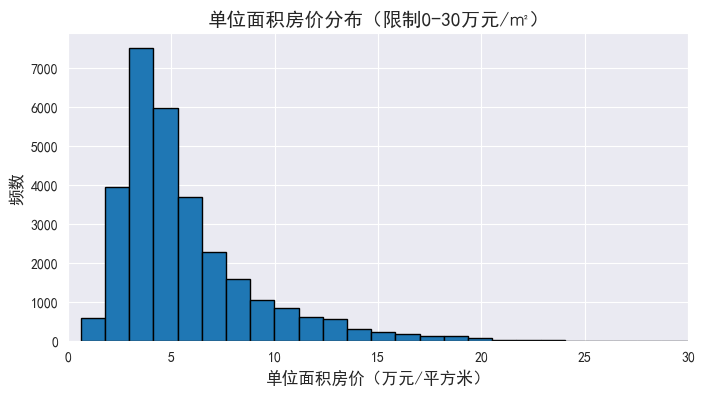

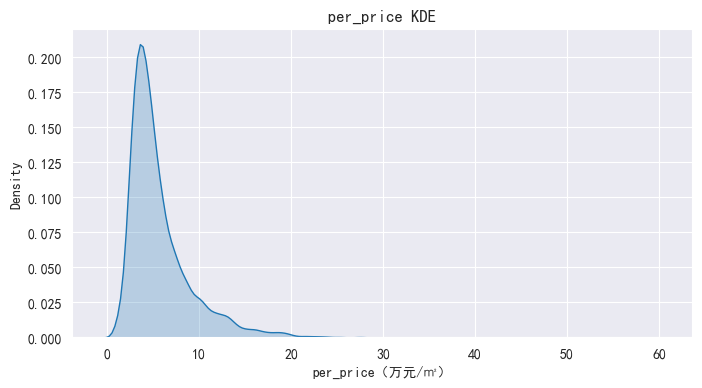

count    29904.000000
mean         5.695858
std          3.555464
min          0.620300
25%          3.429800
50%          4.635450
75%          6.818100
max         59.146900
Name: per_price, dtype: float64
0.01     1.435023
0.05     2.277115
0.25     3.429800
0.50     4.635450
0.75     6.818100
0.95    12.869430
0.99    18.657482
Name: per_price, dtype: float64


In [2]:
# ==============================
# 03_探索性数据分析（EDA）
# ==============================
import pandas as pd
from matplotlib import pylab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
# 设置中文字体
pylab.rcParams['font.sans-serif'] = ['SimHei']
pylab.rcParams['axes.unicode_minus'] = False

# 读取数据（使用你清洗后的文件）
df = pd.read_excel(r'E:\shenzhen_house_price_project\data\clean\清洗后数据.xlsx')
# =============================================================================
# (一) 因变量分析：per_price（万元/㎡）
# =============================================================================
# -----------------------------
# 1.1 分布检查
# -----------------------------
# 直方图
plt.figure(figsize=(8,4))
plt.hist(df['per_price'].dropna(), bins=50, edgecolor='k')
plt.xlim(0, 30)
plt.xlabel('单位面积房价（万元/平方米）', fontsize=12)
plt.ylabel('频数', fontsize=12)
plt.title('单位面积房价分布（限制0-30万元/㎡）', fontsize=14)
plt.show()

# KDE
plt.figure(figsize=(8,4))
sns.kdeplot(df['per_price'].dropna(), fill=True)
plt.xlabel('per_price（万元/㎡）')
plt.title('per_price KDE')
plt.show()

# 描述统计
desc = df['per_price'].describe()
qs = df['per_price'].quantile([0.01,0.05,0.25,0.5,0.75,0.95,0.99])
print(desc)
print(qs)

分析：

均值（5.70）明显大于中位数（4.64）
→ 典型右偏分布（高价房把均值拉高）

四分位距（3.43~6.82）相对集中，而 max=59.15
→ 主体分布集中，但存在远高于正常区间的高价点

95% 分位 = 12.87，是中位数的 2.8 倍
→ 表明右尾长尾明显（高端房价把尾部拉长）

99% 分位 = 18.66，不算离谱（≈95% 的 1.45 倍）
→ 表明虽有长尾，但极端跃升并不剧烈
→ 不像那种 95%=10、99%=100 的极端异常情况

直方图 + KDE 会显示长尾逐渐抬升，且主体集中在 3–7 区间。

结论：
per_price 的整体分布呈明显右偏。主体价格集中在 3.4–6.8 万元/㎡ 区间，但存在一部分高价房（95% 分位为 12.87）。均值高于中位数（5.70 > 4.64），直方图与 KDE 均显示显著的长尾特征，说明高价房对均值影响明显。

In [3]:
# -----------------------------
# 1.2 偏度
# -----------------------------
from scipy.stats import skew, kurtosis
sk = skew(df['per_price'].dropna())
kt = kurtosis(df['per_price'].dropna(), fisher=False)  # fisher=False 返回普通峰度（3 为正态）
print("偏度 skew =", sk)
print("峰度 kurtosis =", kt)


偏度 skew = 2.3884820631110384
峰度 kurtosis = 14.160669871720785


per_price 的偏度（2.39）与峰度（14.16）均远大于正态分布水平，显示出典型的右偏且尖峰厚尾分布。这说明房价存在大量高价异常值，不适合直接用于线性建模，应在后续 EDA 中进行对数变换或异常值处理。

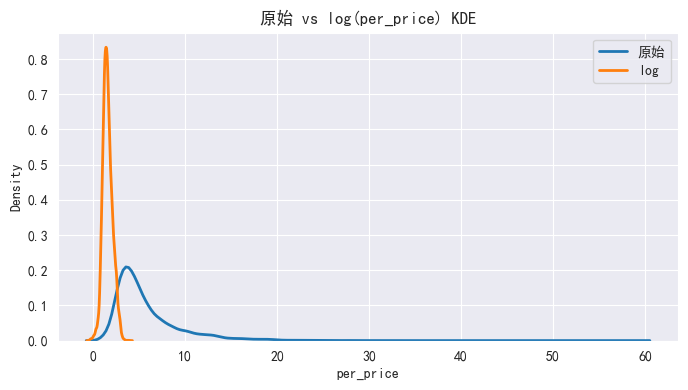

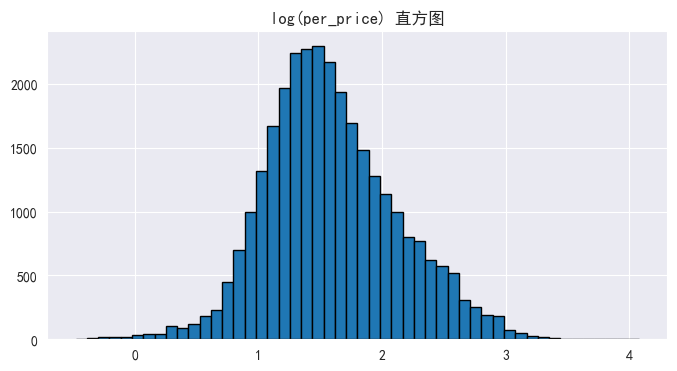

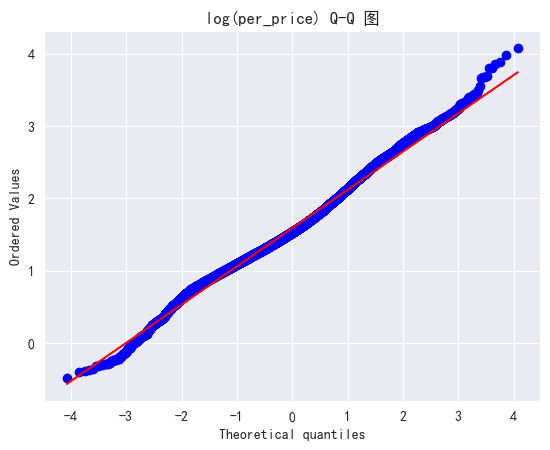

In [4]:
# -----------------------------
# 1.3 对数变换
# -----------------------------
import scipy.stats as stats
df = df.copy()
df['log_price'] = np.log(df['per_price'])

# 对比 KDE
plt.figure(figsize=(8,4))
sns.kdeplot(df['per_price'].dropna(), label='原始', lw=2)
sns.kdeplot(df['log_price'].dropna(), label='log', lw=2)
plt.legend()
plt.title('原始 vs log(per_price) KDE')
plt.show()

# log 的直方图
plt.figure(figsize=(8,4))
plt.hist(df['log_price'].dropna(), bins=50, edgecolor='k')
plt.title('log(per_price) 直方图')
plt.show()

# Q-Q plot（检验正态性）
import pylab
stats.probplot(df['log_price'].dropna(), dist="norm", plot=pylab)
pylab.title('log(per_price) Q-Q 图')
pylab.show()


对数变换后，价格分布明显收敛，峰度与偏度显著下降，分布更接近正态。log(per_price) 作为建模目标（如回归）更合理，也能减弱强异常值对模型参数的干扰。

IQR bounds: lower=-1.653, upper=11.901
异常值数量: 1965 / 29904 (6.57%)


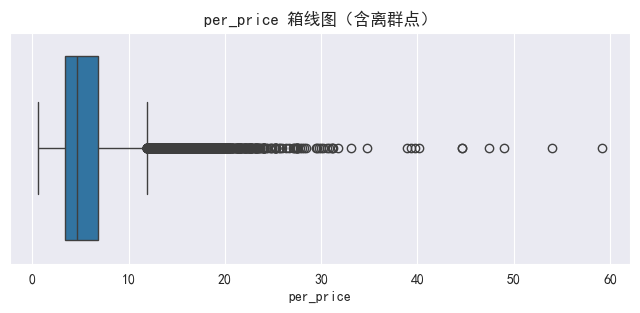

In [5]:
# -----------------------------
# 1.4 极端值检测（IQR、箱线图）
# -----------------------------
Q1 = df['per_price'].quantile(0.25)
Q3 = df['per_price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['per_price'] < lower) | (df['per_price'] > upper)]
outlier_count = len(outliers)
total = df['per_price'].dropna().shape[0]
print(f"IQR bounds: lower={lower:.3f}, upper={upper:.3f}")
print(f"异常值数量: {outlier_count} / {total} ({outlier_count/total:.2%})")

# 箱线图（显示离群点）
plt.figure(figsize=(8,3))
sns.boxplot(x=df['per_price'].dropna())
plt.title('per_price 箱线图（含离群点）')
plt.show()


基于 IQR 方法，per_price 的下界为 -1.653，上界为 11.901，共识别出 1965 条异常记录，占全部样本的 6.57%。
由于房价分布本身具有明显的右偏和重尾特征，IQR 对此类 heavy-tail 数据不够稳健，因此将大量真实的高端房源（15–60 万/㎡）判断为离群点。
箱线图显示这些高价样本在尾部呈连续分布，属于市场结构性极端值，而非数据错误。因此不建议直接删除这些样本。后续建模将采用 log(per_price) 以弱化极端值影响，若有必要可对顶端 1% 样本进行轻度 Winsorize，以提高模型稳健性。

📌 AREA 描述统计
min        13.870000
mean      103.081402
median     89.000000
max       960.000000
std        52.367763
skew        2.329928
kurt        9.852521
Name: AREA, dtype: float64



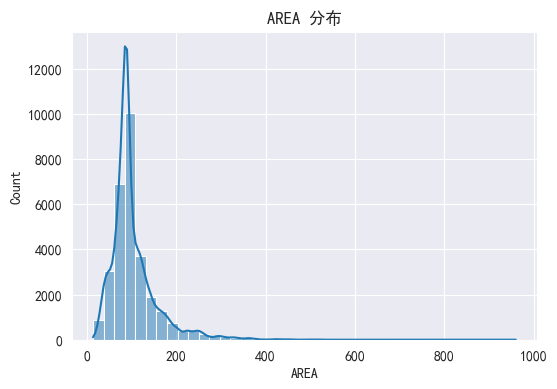

AREA IQR Bounds: lower=13.18, upper=180.71
异常值数量：2185 / 29904 (7.31%)


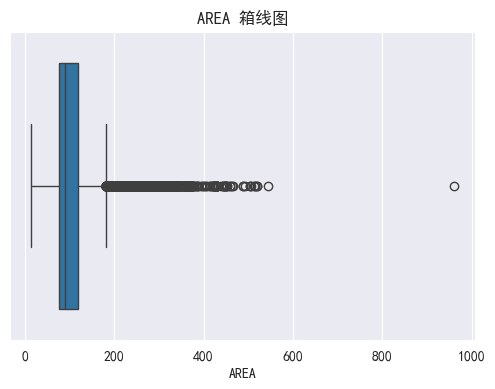

In [6]:
# =============================================================================
# (二) 自变量整体情况-单变量分析
# =============================================================================
# -----------------------------
# 2.1 连续变量: AREA
# -----------------------------
print("="*40)
print("📌 AREA 描述统计")
print(df['AREA'].agg(['min','mean','median','max','std','skew','kurt']))
print()

# 分布图
plt.figure(figsize=(6,4))
sns.histplot(df['AREA'], bins=40, kde=True)
plt.title("AREA 分布")
plt.show()

# IQR 异常值
Q1 = df['AREA'].quantile(0.25)
Q3 = df['AREA'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = ((df['AREA'] < lower) | (df['AREA'] > upper)).sum()

print(f"AREA IQR Bounds: lower={lower:.2f}, upper={upper:.2f}")
print(f"异常值数量：{outliers} / {len(df)} ({outliers/len(df):.2%})")
print("="*80)

plt.figure(figsize=(6,4))
sns.boxplot(x=df['AREA'])
plt.title("AREA 箱线图")
plt.show()

AREA 呈 右偏长尾分布，主体面积约 60–120㎡，符合普通住宅结构，但存在一定数量的大面积豪宅，使整体分布偏右。异常值数量适中，属于业务自然现象，应保留并在建模中用稳健方法处理。

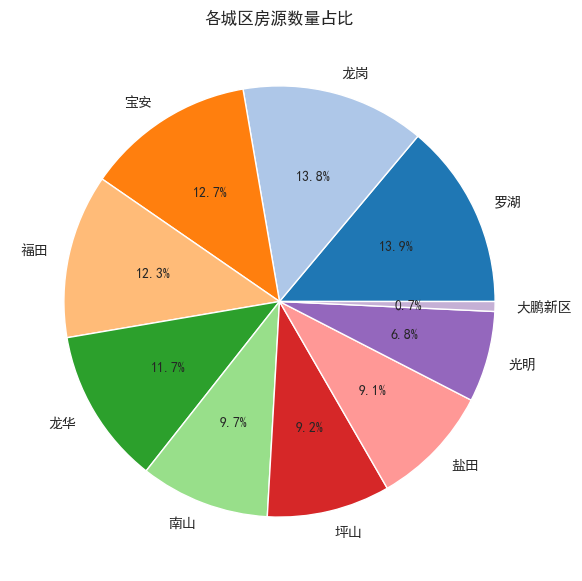

district
罗湖      4159
龙岗      4127
宝安      3790
福田      3680
龙华      3498
南山      2904
坪山      2761
盐田      2723
光明      2041
大鹏新区     221
Name: count, dtype: int64


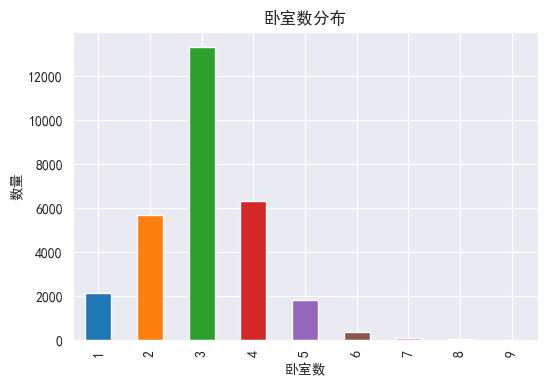

roomnum
3    13311
4     6336
2     5683
1     2139
5     1841
6      375
7      124
8       63
9       32
Name: count, dtype: int64


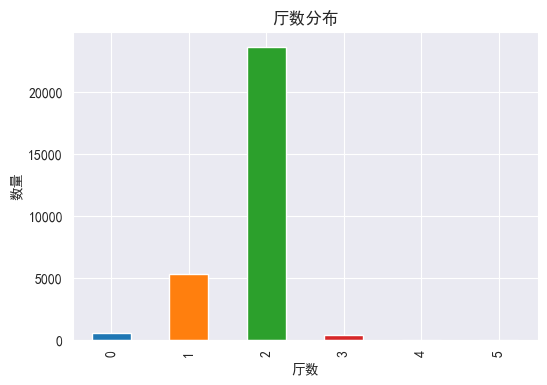

hall
2    23644
1     5305
0      530
3      386
4       27
5       12
Name: count, dtype: int64


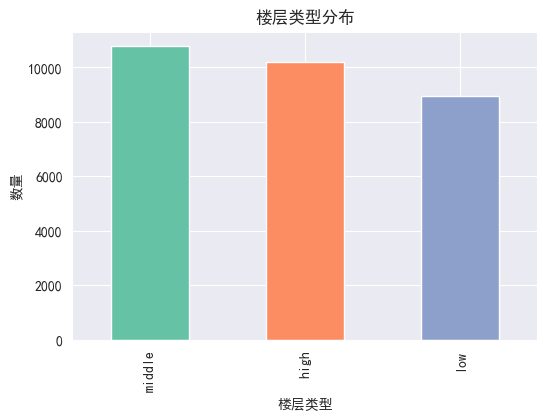

C_floor
middle    10770
high      10192
low        8942
Name: count, dtype: int64


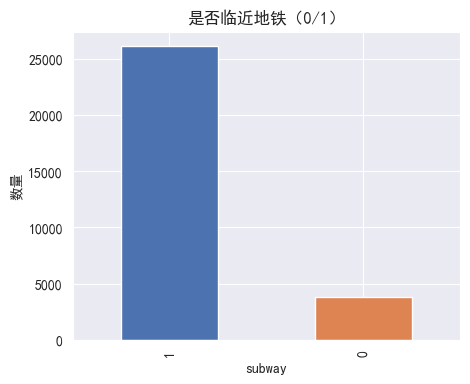

subway
1    26117
0     3787
Name: count, dtype: int64


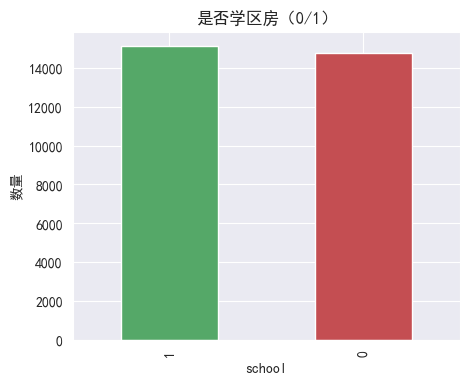

school
1    15113
0    14791
Name: count, dtype: int64


In [7]:
# -----------------------------
# 2.2 分类变量
# -----------------------------

# ① district（城区）
plt.figure(figsize=(7, 7))
df["district"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=sns.color_palette("tab20", df["district"].nunique())
)
plt.title("各城区房源数量占比")
plt.ylabel("")
plt.show()

print(df["district"].value_counts())
print("="*100)


# ② roomnum（卧室数）
plt.figure(figsize=(6, 4))
df["roomnum"].value_counts().sort_index().plot(
    kind="bar",
    color=sns.color_palette("tab10", df["roomnum"].nunique())
)
plt.title("卧室数分布")
plt.xlabel("卧室数")
plt.ylabel("数量")
plt.show()

print(df["roomnum"].value_counts())
print("="*100)


# ③ hall（厅数）
plt.figure(figsize=(6, 4))
df["hall"].value_counts().sort_index().plot(
    kind="bar",
    color=sns.color_palette("tab10")
)
plt.title("厅数分布")
plt.xlabel("厅数")
plt.ylabel("数量")
plt.show()

print(df["hall"].value_counts())
print("="*100)


# ④ C_floor（楼层类型）
plt.figure(figsize=(6, 4))
df["C_floor"].value_counts().plot(
    kind="bar",
    color=sns.color_palette("Set2")
)
plt.title("楼层类型分布")
plt.xlabel("楼层类型")
plt.ylabel("数量")
plt.show()

print(df["C_floor"].value_counts())
print("="*100)


# ⑤ subway（是否临近地铁）
plt.figure(figsize=(5, 4))
df["subway"].value_counts().plot(
    kind="bar",
    color=["#4c72b0", "#dd8452"]
)
plt.title("是否临近地铁（0/1）")
plt.xlabel("subway")
plt.ylabel("数量")
plt.show()

print(df["subway"].value_counts())
print("="*100)


# ⑥ school（是否学区房）
plt.figure(figsize=(5, 4))
df["school"].value_counts().plot(
    kind="bar",
    color=["#55a868", "#c44e52"]
)
plt.title("是否学区房（0/1）")
plt.xlabel("school")
plt.ylabel("数量")
plt.show()

print(df["school"].value_counts())
print("="*100)


============== 双变量分析 ==============


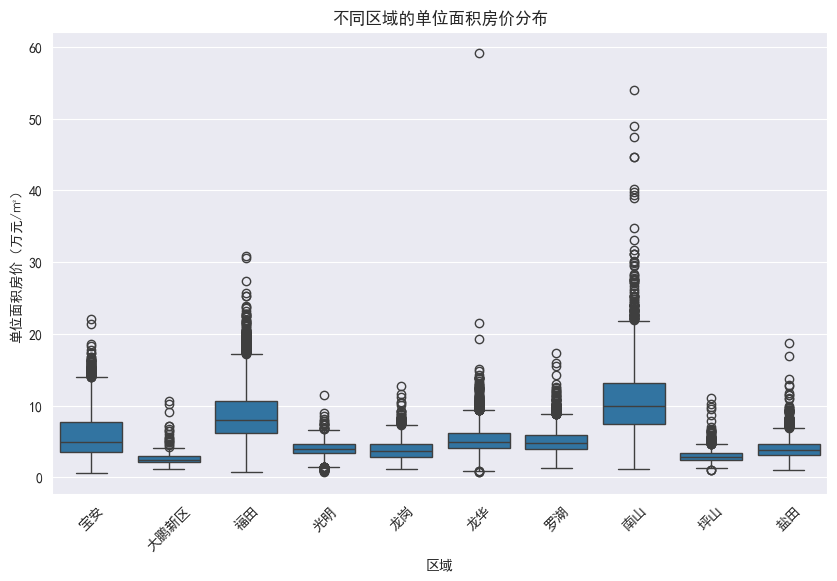

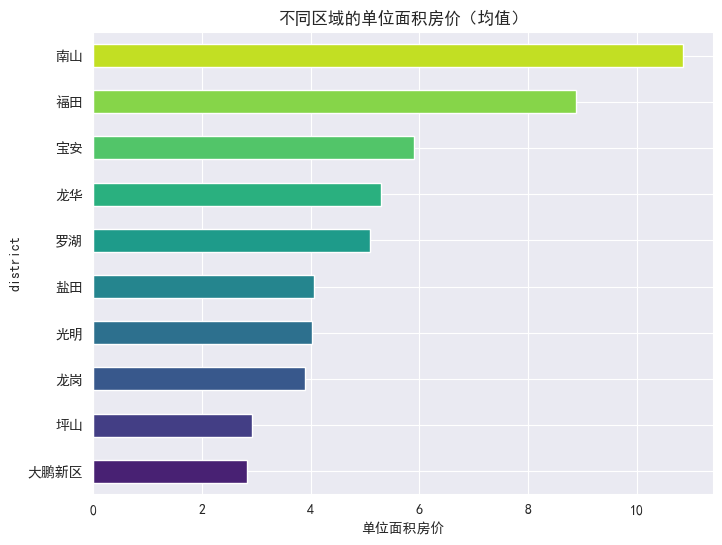

In [20]:
# ============================================
# （三）双变量分析 Bivariate Analysis
# ============================================

print("============== 双变量分析 ==============")

# -----------------------------
# 3.1 分类变量 vs per_price
# -----------------------------

# ① district vs per_price
plt.figure(figsize=(10, 6))
sns.boxplot(x="district", y="per_price", data=df)
plt.title("不同区域的单位面积房价分布")
plt.xlabel("区域")
plt.ylabel("单位面积房价（万元/㎡）")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 6))
mean_price = df.groupby("district")["per_price"].mean().sort_values()
mean_price.plot(kind="barh", color=sns.color_palette("viridis", len(mean_price)))
plt.title("不同区域的单位面积房价（均值）")
plt.xlabel("单位面积房价")
plt.show()


该图（箱线图）展示了各区域房价的分布形态与离散程度：

南山和福田不仅中位数最高，而且价格范围广、离群值多，表明这两个区域既有普通住宅也有顶级豪宅，市场层级丰富。

宝安、龙华等区域价格分布较集中，说明房价相对均衡。

大鹏新区和坪山价格较低，且分布较窄，反映出开发成熟度不高或供应同质化。

盐田虽均价不高，但存在少量高价样本，可能因海景资源稀缺导致局部溢价。

📌 总体而言，南山、福田具备更强的价格弹性与市场活力，而外围区域则偏向刚需或改善型市场。


从均值来看，深圳各区域的房价存在显著差异。南山以约10.8万元/㎡位居首位，是全市房价最高的区域；其次是福田（约8.8万元/㎡），显示出其作为核心城区的高价值。宝安和龙华次之，分别为约5.8万和5.2万元/㎡。而大鹏新区与坪山最低，均低于3万元/㎡，反映出这些区域仍处于发展初期或远离市中心。

整体呈现“中心高、外围低”的空间梯度特征。

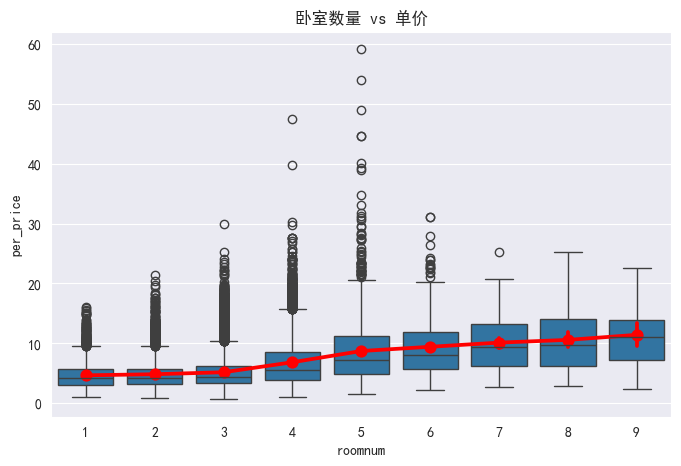

In [21]:
# ② roomnum vs per_price
plt.figure(figsize=(8, 5))
sns.boxplot(x="roomnum", y="per_price", data=df)
sns.pointplot(x="roomnum", y="per_price", data=df, color="red")
plt.title("卧室数量 vs 单价")
plt.show()

卧室数量与单价之间呈弱正相关关系。随着卧室数量增加（从1到9间），单位面积价格中位数略有上升，但增幅不明显。尤其在4-5间房后增长趋于平缓。值得注意的是，5间房的样本中出现大量离群值（异常高价），可能反映高端住宅或特殊户型。

总体而言，卧室数量对单价影响有限，更多体现为居住功能需求而非价格主导因素。

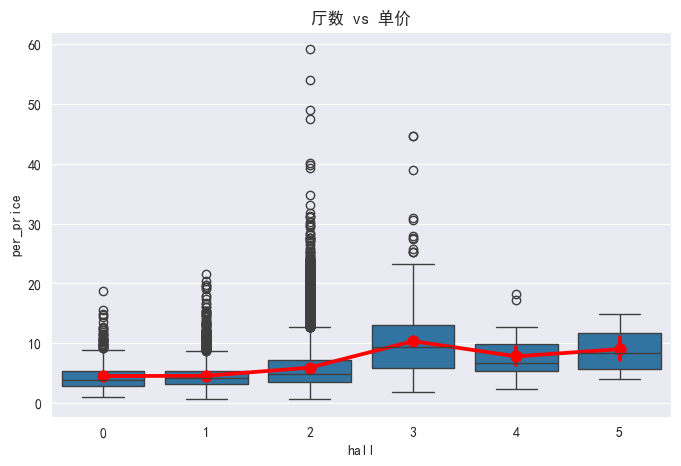

In [22]:
# ③ hall vs per_price
plt.figure(figsize=(8, 5))
sns.boxplot(x="hall", y="per_price", data=df)
sns.pointplot(x="hall", y="per_price", data=df, color="red")
plt.title("厅数 vs 单价")
plt.show()

厅数与单价的关系较为复杂。虽然趋势线显示轻微上升趋势，但实际分布波动较大。2厅房屋价格变异最大，存在多个极端高价样本，说明部分两厅户型可能是大户型或豪华装修所致。3厅及以上户型价格趋于稳定，且中位数略高于其他类型。

整体看，厅数并非决定单价的核心变量，但2厅可能是市场上的“性价比”选择之一。

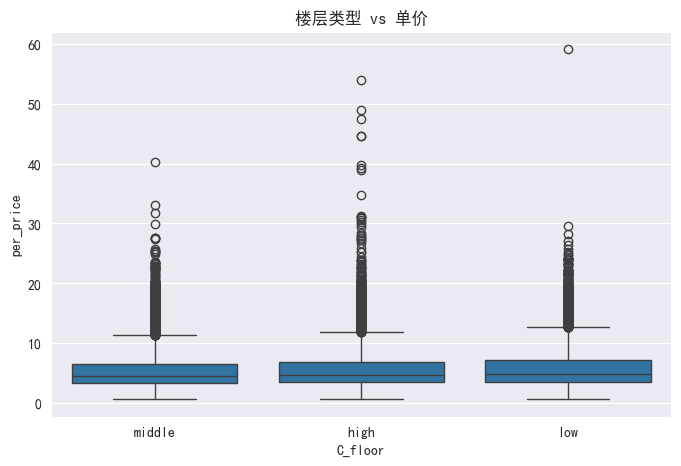

In [23]:
# ④ C_floor vs per_price
plt.figure(figsize=(8, 5))
sns.boxplot(x="C_floor", y="per_price", data=df)
plt.title("楼层类型 vs 单价")
plt.show()


楼层类型对单价的影响较小。high（高层）、middle（中层） 和 low（低层） 三类的中位数基本持平，均集中在6-8万元/㎡区间。

尽管高层有较多离群点（高价样本），表明部分高层豪宅溢价较高，但从整体分布看，楼层本身不是显著影响房价的因素。这可能与城市规划、建筑密度及居民偏好有关，高层并不普遍带来更高单价。

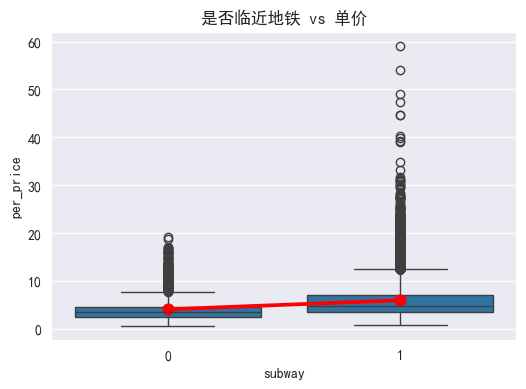

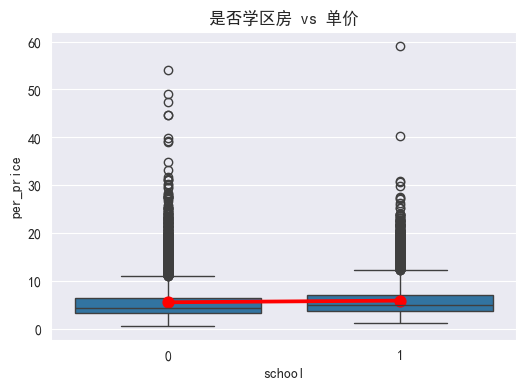

In [24]:
# ⑤ subway vs per_price
plt.figure(figsize=(6, 4))
sns.boxplot(x="subway", y="per_price", data=df)
sns.pointplot(x="subway", y="per_price", data=df, color="red")
plt.title("是否临近地铁 vs 单价")
plt.show()


# ⑥ school vs per_price
plt.figure(figsize=(6, 4))
sns.boxplot(x="school", y="per_price", data=df)
sns.pointplot(x="school", y="per_price", data=df, color="red")
plt.title("是否学区房 vs 单价")
plt.show()


是否地铁房（subway）： 标记为“1”（靠近地铁）的房源，其单价中位数明显高于非地铁房（“0”），且价格分布更集中于高位。

说明地铁便利性显著提升房产价值，是购房者的重要考量因素。
是否学区房： 同样地，“1”代表学区房的样本，其价格中位数也显著高于非学区房，且存在多个高价离群值。

教育配套是影响房价的关键因素，尤其是在深圳这类重视教育的城市。
✅ 综合来看：地铁和学区属性均能显著推高房价，属于“硬核增值要素”

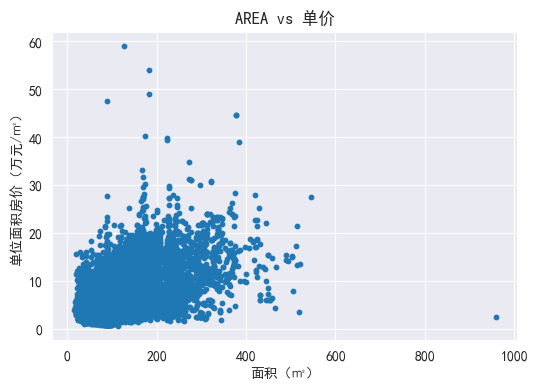

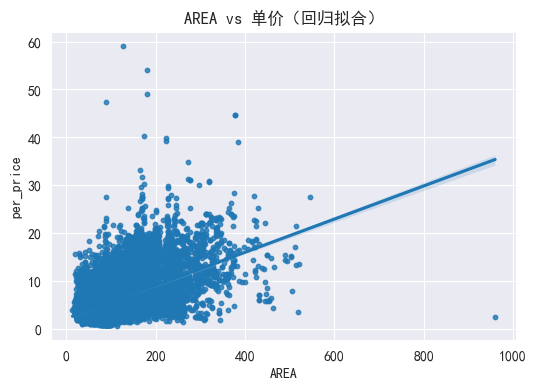

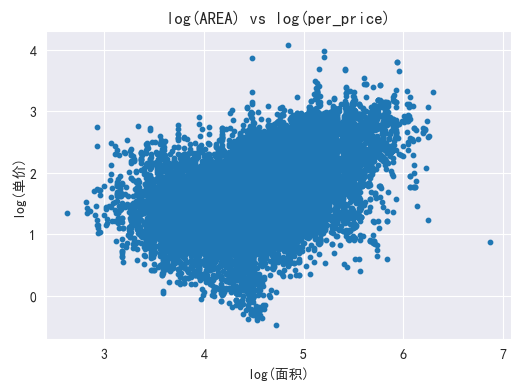

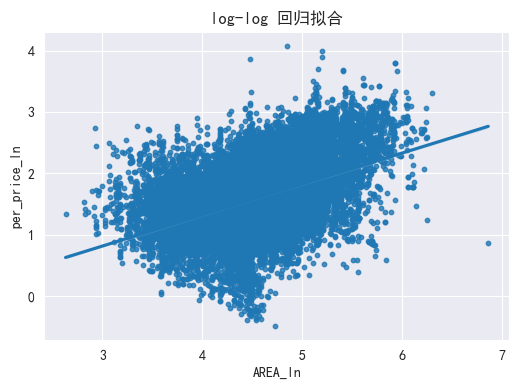

AREA vs 单价 相关系数：0.510
log(AREA) vs log(单价) 相关系数：0.422


In [25]:
# -----------------------------
# 3.2 数值变量 AREA vs per_price
# -----------------------------

# ① 原始散点图
plt.figure(figsize=(6, 4))
plt.scatter(df["AREA"], df["per_price"], s=10)
plt.title("AREA vs 单价")
plt.xlabel("面积（㎡）")
plt.ylabel("单位面积房价（万元/㎡）")
plt.show()

# ② 回归拟合线
plt.figure(figsize=(6, 4))
sns.regplot(x="AREA", y="per_price", data=df, scatter_kws={"s": 10})
plt.title("AREA vs 单价（回归拟合）")
plt.show()

# ③ log-log 散点图
df["AREA_ln"] = np.log(df["AREA"])
df["per_price_ln"] = np.log(df["per_price"])

plt.figure(figsize=(6, 4))
plt.scatter(df["AREA_ln"], df["per_price_ln"], s=10)
plt.title("log(AREA) vs log(per_price)")
plt.xlabel("log(面积)")
plt.ylabel("log(单价)")
plt.show()

# ④ log-log 回归
plt.figure(figsize=(6, 4))
sns.regplot(x="AREA_ln", y="per_price_ln", data=df, scatter_kws={"s": 10})
plt.title("log-log 回归拟合")
plt.show()

# ⑤ 相关系数
corr_raw = np.corrcoef(df["AREA"], df["per_price"])[0, 1]
corr_log = np.corrcoef(df["AREA_ln"], df["per_price_ln"])[0, 1]

print(f"AREA vs 单价 相关系数：{corr_raw:.3f}")
print(f"log(AREA) vs log(单价) 相关系数：{corr_log:.3f}")

原始数据中面积与单价的相关系数为 0.510，表明二者存在中等程度正相关。

对数据取自然对数后，log(面积) 与 log(单价) 的相关系数降至 0.422，说明原始关系存在非线性特征。


散点图显示：面积越大，单价越高，但增速放缓，符合“边际递减”规律——即小户型单价随面积增长较快，大户型单价增长缓慢甚至趋于平稳。


回归线斜率小于1，进一步验证了面积对单价的拉动作用随规模扩大而减弱。